In [ ]:
%matplotlib inline

In [ ]:
!pip install gymnasium==1.0.0
!wget https://raw.githubusercontent.com/laktionov/RL-course/refs/heads/2025/hw2/agent_utils.py
!wget https://raw.githubusercontent.com/laktionov/RL-course/refs/heads/2025/hw2/visualisation_utils.py


# HW2: Случай в казино


**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - Stick (0): the player takes no more cards
 - Hit (1): the player will be given another card, however the player could get over 21 and bust





## Imports and Environment Setup




In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym

## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




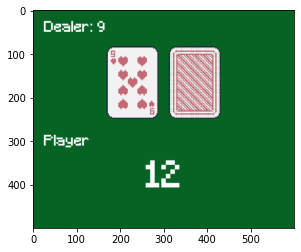

In [7]:
# reset the environment to get the first observation
env = gym.make("Blackjack-v1", sab=True, render_mode="rgb_array")
state, _ = env.reset()

plt.imshow(env.render())

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Task 0: Create and train Q-learning agent (0 point)


In [142]:
from typing import TypeAlias

StateType: TypeAlias = tuple[int, int, bool]


class Agent:
    def __init__(
        self,
        n_actions: int,
        learning_rate: float,
        epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.n_actions = n_actions
        self.q_values = defaultdict(lambda: np.zeros(n_actions))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = epsilon

        self.mse = []

    def on_episode_start(self):
        pass

    def get_best_action(self, state: StateType):
        return #YOUR_CODE

    def get_action(self, state: StateType) -> int:
        # with probability epsilon return a random action to explore the environment
        #YOUR_CODE


class QLearningAgent(Agent):
    def get_value(self, state: StateType):
        return #YOUR_CODE

    def update(
        self,
        state: StateType,
        action: int,
        reward: float,
        terminated: bool,
        next_state: StateType,
    ):
        """Updates the Q-value of an action."""
        next_q_value = (1 - terminated) * self.get_value(next_state)
        td_error = #YOUR_CODE

        self.q_values[state][action] = #YOUR_CODE
        self.mse.append(td_error**2)

To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.

Now we should be ready to build the training loop.




In [ ]:
from agent_utils import train_agent

n_episodes = 300_000
learning_rate = 4e-3
n_actions = env.action_space.n
epsilon = 1.0

env = gym.make("Blackjack-v1", sab=True)
q_learning_agent = QLearningAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
)
train_agent(q_learning_agent, env, n_episodes, epsilon_decay=0.9)

# Task 1: Implement Sarsa($\lambda$) (up to 1 point)

### 1.1 Eligibility Traces

Eligibility traces are a mechanism to bridge between TD(0) methods and Monte-Carlo methods. They "trace" the states (and actions) visited recently, decaying over time, allowing updates to propagate backwards quickly.

### 1.2. Sarsa($\lambda$)

Sarsa($\lambda$) is an **on-policy** method that uses eligibility traces $e(s, a)$

Initialise $Q(s, a)$

Initialise $e(s, a)$ with zeros on each episode start

1. Sample $a_t \sim \mu(.|s_t)$, where $\mu(.|s_t)$ is $\epsilon$-greedy policy w.r.t. current approximation of $Q$.
2. Observe $r_t$ and $s_{t+1}$
3. Calculate $ \delta_t = r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t),$
4. $ e(s_t, a_t) \leftarrow e(s_t, a_t) + 1 $
5. For **all** state-action pairs $(s, a)$:
   * $Q(s,a) \leftarrow Q(s,a) + \alpha \delta_t \cdot e(s,a)$

   * $e(s,a) \leftarrow \gamma \lambda \cdot e(s,a)$

Sarsa($\lambda$) uses the **action taken** by the current policy (often $\epsilon$-greedy w.r.t. $Q$) for the bootstrap term.

In [163]:
class SarsaAgent(Agent):
    def __init__(
        self,
        n_actions: int,
        learning_rate: float,
        epsilon: float,
        decay_factor: float,
        discount_factor: float = 0.95,
    ):
        super().__init__(n_actions, learning_rate, epsilon, discount_factor)
        self.decay_factor = decay_factor
        self.on_episode_start()

    def on_episode_start(self):
        self.e_traces = defaultdict(lambda: np.zeros(self.n_actions))

    def get_value(self, state: StateType):
        #YOUR_CODE

    def update(
        self,
        state: StateType,
        action: int,
        reward: float,
        terminated: bool,
        next_state: StateType,
    ):
        next_q_value = (1 - terminated) * self.get_value(next_state)
        td_error = #YOUR_CODE
        self.e_traces[state][action] = #YOUR_CODE
        self.q_values[state][action] = #YOUR_CODE
        for s in self.e_traces:
            self.e_traces[s] = #YOUR_CODE

        self.mse.append(td_error**2)

In [ ]:
n_episodes = 300_000
learning_rate = 4e-3
n_actions = env.action_space.n
epsilon = 1.0

env = gym.make("Blackjack-v1", sab=True)
sarsa_agent = SarsaAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
    decay_factor=0.9,
)
train_agent(sarsa_agent, env, n_episodes, epsilon_decay=0.9)

# Task 2: Implement Expected Value Sarsa($\lambda$) (up to 0.5 point)



In [166]:
class EVSarsaAgent(SarsaAgent):
    def get_value(self, state: StateType):
        #YOUR_CODE
        return value

In [ ]:
env = gym.make("Blackjack-v1", sab=True)
expected_sarsa_agent = EVSarsaAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
    decay_factor=0.9,
)

train_agent(expected_sarsa_agent, env, n_episodes, epsilon_decay=0.9)

# Task 3: Analysis (up to 0.5 point)

In [ ]:
from visualisation_utils import visualise_strategy
from agent_utils import evaluate_agent


Write a brief report on your experiments. You may want to train several agents with different hyperparameters.

* Use `visualise_strategy` and `evaluate_agent` to support your conclusions.
* Compare the agents' strategies and evaluation performance with default parameters (Q-learning vs Sarsa(0.9) vs EVSarsa(0.9)).
* Compare the agents' strategies and evaluation performance with $\lambda = 0$ (Q-learning vs Sarsa(0) vs EVSarsa(0)). Why don't we use N-step targets or eligibility traces for Q-learning?
* Compare Sarsa($\lambda$) for different $\lambda$ values.
* Draw any conclusions you find relevant.

